In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [49]:
import random

import numpy as np
import altair as alt
import pandas as pd

from scipy.sparse import csr_matrix, lil_matrix
from annoy import AnnoyIndex
from collections import defaultdict
from titlecase import titlecase
from umap import UMAP

from sklearn.decomposition import TruncatedSVD
from sklearn import manifold
from sklearn.decomposition import PCA

from sqlalchemy.dialects.postgresql import array_agg
from sqlalchemy.sql import functions as func

from osp_graphs.v1_db import session, Text, Field, Subfield, SubfieldDocument, Citation, Document

In [110]:
session.rollback()

In [111]:
query = (session
    .query(Citation.document_id, Field.name, array_agg(Citation.text_id), array_agg(Text.title))
    .join(Text, Document, SubfieldDocument, Subfield, Field)
    .filter(Text.valid==True)
    .filter(Text.display==True)
    .having(func.count(Citation.text_id) < 50)
    .having(func.count(Citation.text_id) > 5)
    .group_by(Citation.document_id, Field.name)
    .order_by(func.random()))

In [112]:
query.count()

92009

In [131]:
doc_ids, field_names, doc_text_ids, doc_text_titles = zip(*query.all())

In [132]:
text_ids = list(set([tid for text_ids in doc_text_ids for tid in text_ids]))
text_id_to_idx = {tid: i for i, tid in enumerate(text_ids)}

In [133]:
M = lil_matrix((len(doc_ids), len(text_ids)))

for didx, tids in enumerate(doc_text_ids):
    for tid in tids:
        tidx = text_id_to_idx[tid]
        M[didx, tidx] += 1

In [134]:
M.shape

(92009, 238628)

In [135]:
svd = TruncatedSVD(n_components=10)
svd.fit_transform(M.T)

array([[ 1.73872990e-05,  8.08382195e-04, -2.37779462e-03, ...,
         1.41230438e-03, -4.77889116e-03,  5.58464175e-05],
       [ 3.64869032e-07,  2.77129976e-04,  1.03427626e-04, ...,
         8.86986741e-04, -2.19286421e-05, -6.17189287e-05],
       [ 3.53959060e-07,  1.28505630e-05, -2.27429171e-05, ...,
         4.20568554e-05,  3.48276438e-05,  1.96575731e-05],
       ...,
       [ 2.69450932e-09,  1.02502272e-06, -2.57217149e-06, ...,
         1.09493111e-06, -8.30747562e-08, -5.39351979e-07],
       [ 2.50680377e-06,  1.90133799e-04, -1.78707183e-04, ...,
         8.61252595e-04,  6.14769101e-04,  1.84823318e-04],
       [ 3.64869058e-07,  2.77129976e-04,  1.03427626e-04, ...,
         8.86986742e-04, -2.19286421e-05, -6.17189292e-05]])

In [136]:
svd.components_.T.shape

(92009, 10)

In [137]:
dr = manifold.TSNE(n_components=2, init='pca', metric='cosine', random_state=1)
embedding = dr.fit_transform(svd.components_.T[:5000])

In [145]:
tips = [
    '%s :: %s' % (field.upper(), ' | '.join([titlecase(t.strip(' /.,;')) for t in titles[:5]]))
    for field, titles in zip(field_names, doc_text_titles)
]

In [146]:
rows = [
    (doc_id, field, tip, x, y)
    for doc_id, field, tip, (x, y) in zip(doc_ids, field_names, tips, embedding)
]

df = pd.DataFrame(rows, columns=('doc_id', 'field', 'titles', 'x', 'y'))

In [147]:
chart = (alt
    .Chart(df, width=1000, height=1000)
    .mark_circle()
    .encode(x='x', y='y', tooltip='titles', color='field'))

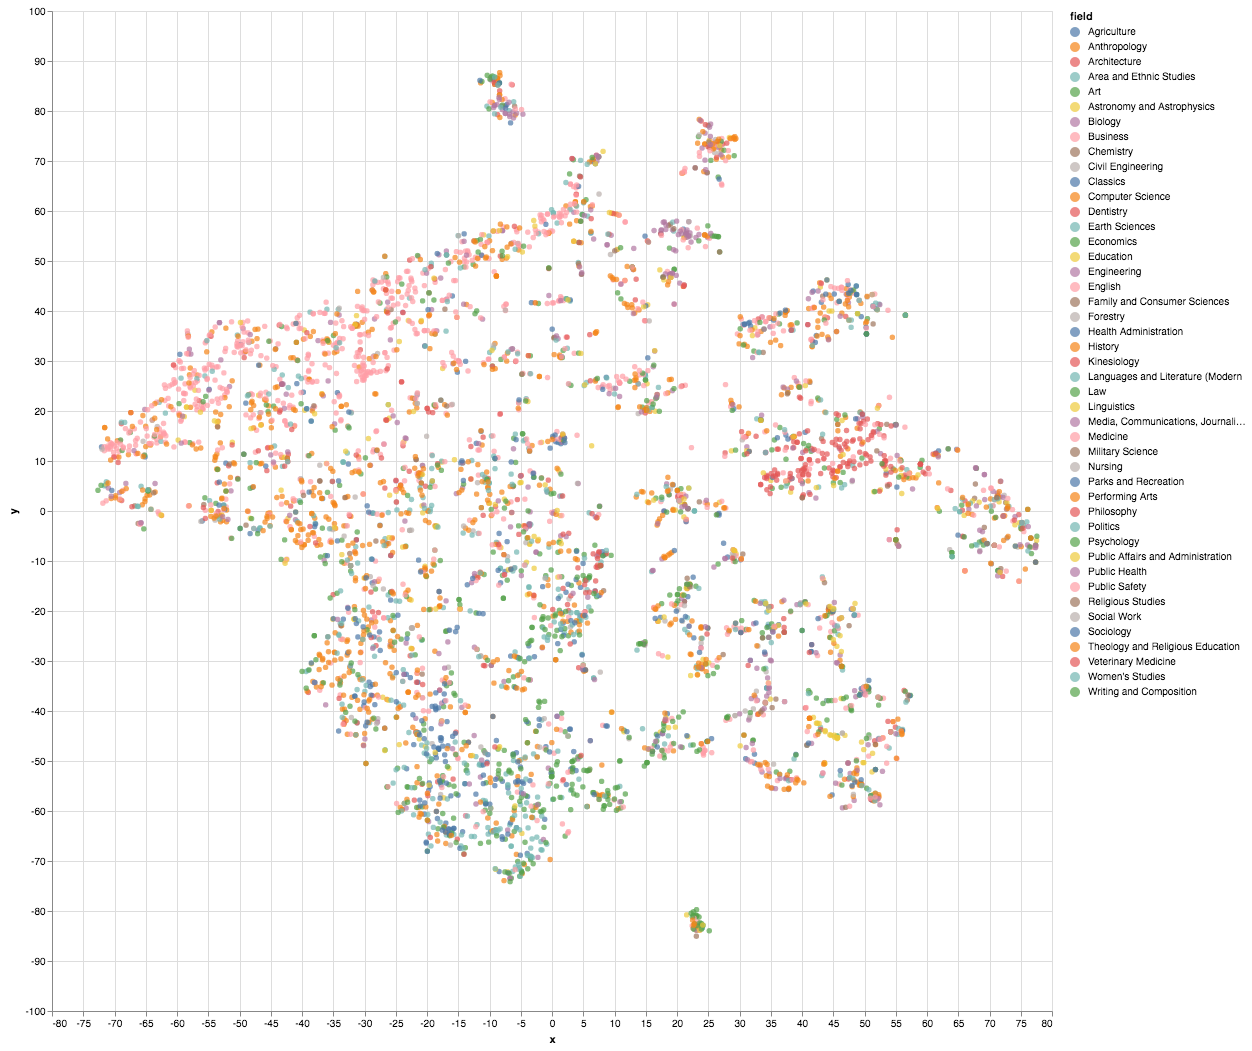

In [148]:
chart.interactive()